<h1 style="color:#191970; font-size:38px">MIMO-NN1</h1>

<h1 style="color:#006400">Libraries</h1>

In [1]:
import numpy as np
from numpy.linalg import inv
from commpy.modulation import QAMModem
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
import matplotlib.pyplot as plt
import decimal
from decimal import getcontext

getcontext().Emax = 600000000000

Using TensorFlow backend.


<h1 style="color:#006400">Functions</h1>

In [2]:
import import_ipynb
from Utils import *

importing Jupyter notebook from Utils.ipynb


<h1 style="color:#006400">Variables</h1>

In [8]:
IBO = 3
p = 1.1
q = 4
Vsat = 1.9
G = 16
A = -345
B = 0.17
Mr = 10
Mt = 100
M = 16
N_bits = Mr * np.log2(M)
SNRdb = decimal.Decimal(60000000000)
Niter = 50
mu1 = 0.0017
lamda = 0.00071
mu2 = 1
eps = 1e-2

<h1 style="color:#006400">Initialization</h1>

In [9]:
N_bits = Mr * np.log2(M)
MSE = np.zeros((Mt, 50))
x_gd_amp0 = np.zeros((Mt, 1))
y_gd_r0 = np.zeros([10000, 100])
PAPR_GD = np.zeros((Mt, 1))
MUIgdi = np.zeros((Mt, 1))
SERgdi = np.zeros((10000, 1))
BERgdi = np.zeros((10000, 1))
x_gd = np.zeros([Mt, 1])
gdx1 = np.zeros([Mt, Niter])
d = np.zeros([Mt, 1])
S = np.zeros((10000, 20))
ZZ = np.zeros((10000, 10), dtype=complex)
X = np.zeros((10000, 200))

<h1 style="color:#006400">Basic_Nonlinear_Distortion_Model</h1>

In [10]:
K0, sigma_2d = Basic_Nonlinear_Distortion_Model(A, B, q, p, G, Vsat, IBO)

<h1 style="color:#006400"> Data </h1>

In [11]:
""" Il s'agit de modeliser le canal de transmission par une matrice complex."""
H = (1 / np.sqrt(2 * Mt)) * (np.random.randn(Mr, Mt) + 1j * np.random.randn(Mr, Mt))
HR = H.flatten()
realh = np.real(HR)
imagh = np.imag(HR)
Hr = np.concatenate((realh, imagh), axis=0).reshape(-1, 1)
Hr = np.reshape(Hr, (2000, 1)).T
HH = Hr

In [12]:
"""Il s'agit de génerer pour chaque H; 1000000 symboles S et 1000000 symboles précodés X.
   C'est l'algorithme de Gradient descente qui permet de minimiser l’erreur quadratique moyenne (MSE) entre les symboles prévus S et les sorties de PA passant par le canal H
   Dans laquelle nous estimons x en minimisant la fonction de coût J (x) par rapport à x et estimons le vecteur de distorsion à travers le chemin de rétroaction. 
   Ainsi, dans la (l + 1) -ième itération, peut être exprimée comme x(l+1) = x(l) −Δx(l) avec Δx(l) = λ∇xJ(x(l),d(l)). """
for j in range(10000):
    bits = np.random.randint(2, size=int(N_bits))  
    QAM16 = QAMModem(16)  
    z = QAM16.modulate(bits)
    Z = np.reshape(z, (1, 10)).T
    ZZ[j] = Z.T
    reals = np.real(Z.T)
    imags = np.imag(Z.T)
    s = np.concatenate((reals, imags), axis=1)
    S[j] = s
    for i in range(Niter):
        gdx1 = 2 * np.conj(K0 * np.transpose(H)).dot(K0 * H.dot(x_gd) + H.dot(d) - Z)
        x_gd = x_gd - mu1 * gdx1
        realx = np.real(x_gd)
        imagx = np.imag(x_gd)
        x_z = np.concatenate((realx, imagx), axis=0).T
        X[j] = x_z
        val_IBO_m1dB = (
            ((1 / np.sqrt(10 ** -0.1)) ** (2 * p) - 1) ** (1 / (2 * p)) * Vsat / (G)
        )
        coeff_IBO_m1dB = (
            val_IBO_m1dB * np.sqrt((1 / np.var(x_gd))) * np.sqrt(10 ** (-IBO / 10))
        )  
        vin2 = coeff_IBO_m1dB * x_gd
        vout2 = hpa_sspa_modif_rapp(
            vin2, Vsat, p, q, G, A, B
        ) 
        K0, sigma2_d = find_K0_sigma2_d(vin2, vout2)
        d = vout2 - K0 * vin2  
        y_gd = np.array(vout2 / coeff_IBO_m1dB)  
       

In [13]:
#from numpy import load 
#X=load('xdatax.npy')
#S=load('sdatas.npy')


In [16]:
"Base d'apprentissage"
X_train = S[:9000, :]
y_train = X[:9000, :]
"Base de test"
X_test = S[9000:, :]
y_test = X[9000:, :]

In [17]:
""" Save S transmitted symbols vector and X precoded symbols vector in datas.npy and datax.npy files """
from numpy import save
save('dataX00-.npy', X)
save('dataS00-.npy',S)

<h1 style="color:#006400">NN1 Model Architecture</h1>

In [27]:
keras.optimizers.Adamax(learning_rate=0.9, beta_1=0.999, beta_2=0.999)
model=Sequential()
model.add(Dense(units=100, kernel_initializer="uniform", activation="relu", input_dim=20))
model.add(Dense(units=200, kernel_initializer="uniform", activation="linear"))
model.compile(optimizer="Adamax", loss="mae", metrics=['mse'])
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=10000,
    epochs=3000,
    shuffle=True,
)



Train on 9000 samples, validate on 1000 samples
Epoch 1/3000
9000/9000 [==============================] - 0s 7us/step - loss: 0.0617 - mse: 0.0060 - val_loss: 0.0563 - val_mse: 0.0050
Epoch 2/3000
9000/9000 [==============================] - 0s 2us/step - loss: 0.0567 - mse: 0.0051 - val_loss: 0.0518 - val_mse: 0.0043
Epoch 3/3000
9000/9000 [==============================] - 0s 3us/step - loss: 0.0522 - mse: 0.0043 - val_loss: 0.0483 - val_mse: 0.0037
Epoch 4/3000
9000/9000 [==============================] - 0s 3us/step - loss: 0.0487 - mse: 0.0038 - val_loss: 0.0456 - val_mse: 0.0033
Epoch 5/3000
9000/9000 [==============================] - 0s 2us/step - loss: 0.0459 - mse: 0.0033 - val_loss: 0.0428 - val_mse: 0.0029
Epoch 6/3000
9000/9000 [==============================] - 0s 2us/step - loss: 0.0431 - mse: 0.0030 - val_loss: 0.0406 - val_mse: 0.0026
Epoch 7/3000
9000/9000 [==============================] - 0s 2us/step - loss: 0.0409 - mse: 0.0027 - val_loss: 0.0386 - val_mse: 0.0024


<h1 style="color:#006400"> Loss Representation</h1>

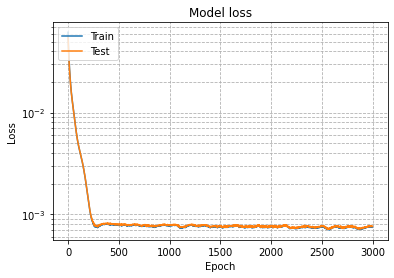

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.grid(True,which="both", linestyle='--')
plt.ylabel('Loss') 
plt.yscale('log')
plt.xlabel('Epoch')
plt.legend(['Train','Test'], loc='upper left')
plt.show()

In [29]:
y_pred = model.predict(X_train)
y_predt = model.predict(X_test)

In [30]:

NMSE = np.zeros([1000, 1])
recievehh = np.zeros([1000, 10], dtype=complex)
Y_gdr = y_predt[:1000, :100]
Y_gdi = 1j * y_predt[:1000, 100:]
Y_gd = Y_gdr + Y_gdi
Shr = X_test[:1000, :10]
Shi = 1j * X_test[:1000, 10:20]
SSh = Shr + Shi
for i in range(1000):
    val_IBO_m1dB = (
        ((1 / np.sqrt(10 ** -0.1)) ** (2 * p) - 1) ** (1 / (2 * p)) * Vsat / (G)
    )
    coeff_IBO_m1dB = (
        val_IBO_m1dB * np.sqrt((1 / np.var(Y_gd[i]))) * np.sqrt(10 ** (-IBO / 10))
    )
    vin2 = coeff_IBO_m1dB * Y_gd[i]
    vout2 = hpa_sspa_modif_rapp(vin2, Vsat, p, q, G, A, B)
    Y_gd_amp = vout2 / coeff_IBO_m1dB
    recieveh = (H.dot(Y_gd_amp)).reshape((10))
    recievehh[i] = recieveh
    NMSE[i] = np.mean(np.abs(SSh[i] -  recieveh) ** 2) / np.mean(np.abs(SSh[i]) ** 2)
    NMSEdb = 10 * np.log10(np.mean(NMSE))
print(NMSEdb)



-32.363382589431026


In [31]:

SNRdb=8
NMSE = np.zeros([1000, 1])
recievehh = np.zeros([1000, 10], dtype=complex)
Y_gdr = y_predt[:1000, :100]
Y_gdi = 1j * y_predt[:1000, 100:]
Y_gd = Y_gdr + Y_gdi
Shr = X_test[:1000, :10]
Shi = 1j * X_test[:1000, 10:20]
SSh = Shr + Shi
for i in range(1000):
    val_IBO_m1dB = (
        ((1 / np.sqrt(10 ** -0.1)) ** (2 * p) - 1) ** (1 / (2 * p)) * Vsat / (G)
    )
    coeff_IBO_m1dB = (
        val_IBO_m1dB * np.sqrt((1 / np.var(Y_gd[i]))) * np.sqrt(10 ** (-IBO / 10))
    )
    vin2 = coeff_IBO_m1dB * Y_gd[i]
    vout2 = hpa_sspa_modif_rapp(vin2, Vsat, p, q, G, A, B)
    Y_gd_amp = vout2 
    recieveh = (H.dot(Y_gd_amp)).reshape((10))
    recievehh[i] = recieveh
    SNRlin=pow(10,SNRdb/10)
    sigmas2=np.var(Z)
    sigma2=(sigmas2/(2*(SNRlin)))
    sigmas2gd=np.var(Y_gd_amp)
    sigma2gd=(sigmas2gd/(2*(SNRlin)))
    wgd = np.sqrt(sigma2gd)*(np.random.randn(Mr,1)+1j*np.random.randn(Mr,1))
    y_gd_r = recieveh + wgd.T
    y_gd_r =y_gd_r / coeff_IBO_m1dB
    NMSE[i] = np.mean(np.abs(SSh[i] - y_gd_r) ** 2) / np.mean(np.abs(SSh[i]) ** 2)
    NMSEdb = 10 * np.log10(np.mean(NMSE))
    cc=y_gd_r.T     
    Aa = QAM16.demodulate(cc, demod_type="hard", noise_var=0)
    bitest=QAM16.demodulate(SSh[i], demod_type="hard", noise_var=0)
    BERgdi[i]=np.sum(Aa!=bitest)/(Mr*log2(M))
    #BERgd = np.mean(BERgdi[i])

BERgd = np.mean(BERgdi)

print(SNRdb)
print(BERgd)


8
8e-05


-3
0.016305
-2
0.0133775
-1
0.010647499999999999
0
0.0082
1
0.0063175
2
0.004327500000000001
3
0.0026375
4
0.0016274999999999998
5
0.0007925
6
0.0003975
7
0.00018250000000000002
8
4.7499999999999996e-05
9
1.5000000000000002e-05
10
5e-06
5e-06


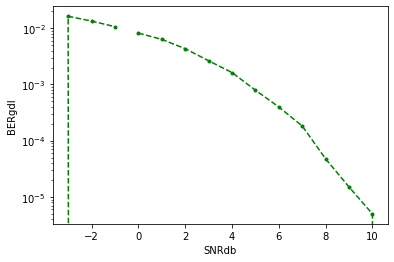

In [32]:
NMSEdbl=np.zeros((15, 1))
BERgdl=np.zeros((15, 1))
SNRdbl=np.zeros((15, 1))
for l in range(-3,11):
    SNRdb=l
    SNRdbl[l]=SNRdb
    NMSE = np.zeros([1000, 1])
    recievehh = np.zeros([1000, 10], dtype=complex)
    Y_gdr = y_predt[:1000, :100]
    Y_gdi = 1j * y_predt[:1000, 100:]
    Y_gd = Y_gdr + Y_gdi
    Shr = X_test[:1000, :10]
    Shi = 1j * X_test[:1000, 10:20]
    SSh = Shr + Shi
    for i in range(1000):
        val_IBO_m1dB = (
            ((1 / np.sqrt(10 ** -0.1)) ** (2 * p) - 1) ** (1 / (2 * p)) * Vsat / (G)
        )
        coeff_IBO_m1dB = (
            val_IBO_m1dB * np.sqrt((1 / np.var(Y_gd[i]))) * np.sqrt(10 ** (-IBO / 10))
        )
        vin2 = coeff_IBO_m1dB * Y_gd[i]
        vout2 = hpa_sspa_modif_rapp(vin2, Vsat, p, q, G, A, B)
        Y_gd_amp = vout2 
        recieveh = (H.dot(Y_gd_amp)).reshape((10))
        recievehh[i] = recieveh
        SNRlin=pow(10,SNRdb/10)
        sigmas2=np.var(Z)
        sigma2=(sigmas2/(2*(SNRlin)))
        sigmas2gd=np.var(Y_gd_amp)
        sigma2gd=(sigmas2gd/(2*(SNRlin)))
        wgd = np.sqrt(sigma2gd)*(np.random.randn(Mr,1)+1j*np.random.randn(Mr,1))
        y_gd_r = recieveh + wgd.T
        y_gd_r =y_gd_r / coeff_IBO_m1dB
        NMSE[i] = np.mean(np.abs(SSh[i] - y_gd_r) ** 2) / np.mean(np.abs(SSh[i]) ** 2)
        NMSEdb = 10 * np.log10(np.mean(NMSE))
        cc=y_gd_r.T     
        Aa = QAM16.demodulate(cc, demod_type="hard", noise_var=0)
        bitest=QAM16.demodulate(SSh[i], demod_type="hard", noise_var=0)
        BERgdi[i]=np.sum(Aa!=bitest)/(Mr*log2(M))
        #BERgd = np.mean(BERgdi[i])
    NMSEdbl[l]=NMSEdb 
    BERgd = np.mean(BERgdi)
    BERgdl[l]=BERgd
    print(SNRdb)
    print(BERgd)
plt.plot(SNRdbl,BERgdl,color="green", marker=".", linestyle="dashed") 
plt.ylabel('BERgdl') 
plt.yscale('log')
plt.xlabel('SNRdb')
print(BERgd)